In [1]:
!pip show gym

Name: gym
Version: 0.25.2
Summary: Gym: A universal API for reinforcement learning environments
Home-page: https://www.gymlibrary.ml/
Author: Gym Community
Author-email: jkterry@umd.edu
License: MIT
Location: /usr/local/lib/python3.9/dist-packages
Requires: cloudpickle, gym-notices, importlib-metadata, numpy
Required-by: dopamine-rl


In [2]:
# !pip install --upgrade gym

# Configuration & Tools

In [3]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install pyvirtualdisplay
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(600, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  freeglut3 libpython2-stdlib python2 python2-minimal
Suggested packages:
  python-tk python-numpy libgle3 python2-doc
The following NEW packages will be installed:
  freeglut3 libpython2-stdlib python-opengl python2 python2-minimal
0 upgraded, 5 newly installed, 0 to remove and 24 not upgraded.
Need to get 621 kB of archives.
After this operation, 6,059 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2-minimal amd64 2.7.17-2ubuntu4 [27.5 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libpython2-stdlib amd64 2.7.17-2ubuntu4 [7,072 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 python2 amd64 2.7.17-2ubuntu4 [26.5 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 freeglut3 amd64 2.8.1-3 [73.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu f

## Import modules

In [4]:
import random
from collections import deque
from typing import Deque, Dict, List, Tuple
import matplotlib.pyplot as plt
import gym
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

from IPython.display import clear_output

## Set random seed

In [5]:
if torch.backends.cudnn.enabled:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay buffer
Typically, people implement replay buffers with one of the following three data structures:

- collections.deque
- list
- numpy.ndarray

**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of Get item is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference), . Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.

Reference: 
- [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)
- [rainbow-is-all-you-need](https://render.githubusercontent.com/view/ipynb?commit=032d11277cf2436853478a69ca5a4aba03202598&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f437572742d5061726b2f7261696e626f772d69732d616c6c2d796f752d6e6565642f303332643131323737636632343336383533343738613639636135613461626130333230323539382f30312e64716e2e6970796e62&nwo=Curt-Park%2Frainbow-is-all-you-need&path=01.dqn.ipynb&repository_id=191133946&repository_type=Repository#Replay-buffer)

In [6]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int=32, save_log_prob=False):
        """Initialize."""
        self.obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.act_buf = np.zeros(size, dtype=np.float32)
        self.rew_buf = np.zeros(size, dtype=np.float32)
        self.next_obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        if save_log_prob:
            self.log_prob_buf = np.zeros(size, dtype=np.float32)
        self.save_log_prob = save_log_prob
        self.ptr, self.size, self.max_size = 0, 0, size
        self.batch_size = batch_size


    def store(self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
        log_prob: float=None
    ):
        """Store the transition in buffer."""
        if self.ptr >= self.max_size:
            self.ptr = 0
        self.obs_buf[self.ptr] = obs
        self.act_buf[self.ptr] = act
        self.rew_buf[self.ptr] = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr] = done
        if log_prob is not None:
            self.log_prob_buf[self.ptr] = log_prob
        self.ptr += 1
        self.size = min(self.size + 1, self.max_size)


    def sample_batch(self) -> Dict[str, np.ndarray]:
        """Randomly sample a batch of experiences from memory."""
        idxs = np.random.randint(0, self.size, size=self.batch_size)
        return dict(
            states=self.obs_buf[idxs],
            actions=self.act_buf[idxs],
            rewards=self.rew_buf[idxs],
            next_states=self.next_obs_buf[idxs],
            dones=self.done_buf[idxs],
            log_probs=self.log_prob_buf[idxs] if self.save_log_prob else None
        )
        

    def __len__(self) -> int:
        """Return the current size of internal memory."""
        return self.size

## OU Noise
**Ornstein-Uhlenbeck** process generates temporally correlated exploration, and it effectively copes with physical control problems of inertia.

$$
dx_t = \theta(\mu - x_t) dt + \sigma dW_t
$$

Reference: 
- [Udacity github](https://github.com/udacity/deep-reinforcement-learning/blob/master/ddpg-pendulum/ddpg_agent.py)
- [Wiki](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process)

In [7]:
import copy

class OUNoise:
    """Ornstein-Uhlenbeck process.
    Taken from Udacity deep-reinforcement-learning github repository:
    https://github.com/udacity/deep-reinforcement-learning/blob/master/
    ddpg-pendulum/ddpg_agent.py
    """

    def __init__(
        self, 
        size: int, 
        mu: float = 0.0, 
        theta: float = 0.15, 
        sigma: float = 0.2,
    ):
        """Initialize parameters and noise process."""
        self.state = np.float64(0.0)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self) -> np.ndarray:
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.random(len(x))
        self.state = x + dx
        return self.state

# PPO

- PPO: [J. Schulman et al., "Proximal Policy Optimization Algorithms." arXiv preprint arXiv:1707.06347, 2017.](https://arxiv.org/abs/1707.06347.pdf)
- TRPO: [Schulman, John, et al. "Trust region policy optimization." International conference on machine learning. 2015.](http://proceedings.mlr.press/v37/schulman15.pdf)

There are two kinds of algorithms of PPO: PPO-Penalty and PPO-Clip. Here, we'll implement PPO-clip version.

TRPO computes the gradients with a complex second-order method. On the other hand, PPO tries to solve the problem with a first-order methods that keep new policies close to old. To simplify the surrogate objective, let $r(\theta)$ denote the probability ratio

$$ L^{CPI}(\theta) = \hat {\mathbb{E}}_t \left [ {\pi_\theta(a_t|s_t) \over \pi_{\theta_{old}}(a_t|s_t)} \hat A_t\right] = \hat {\mathbb{E}}_t \left [ r_t(\theta) \hat A_t \right ].$$

The objective is penalized further away from $r_t(\theta)$

$$ L^{CLIP}(\theta)=\hat {\mathbb{E}}_t \left [ \min(r_t(\theta) \hat A_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat A_t) \right ] $$

If the advantage is positive, the objective will increase. As a result, the action becomes more likely. If advantage is negative, the objective will decrease. AS a result, the action becomes less likely.

# DDPG 

[T. P. Lillicrap et al., "Continuous control with deep reinforcement learning." arXiv preprint arXiv:1509.02971, 2015.](https://arxiv.org/pdf/1509.02971.pdf)

Deep Q Network(DQN)([Mnih et al., 2013;2015](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)) algorithm is combined advances in deep learning with reinforcement learning. However, while DQN solves problems with high-dimentional observation spaces, it can only handle discrete and low-dimentional action spaces because of using greedy policy. For learning in high-dimentional and continous action spaces, the authors combine the actor-critic approach with insights from the recent success of DQN. Deep DPG(DDPG) is based on the deterministic policy gradient(DPG) algorithm ([Silver et al., 2014](http://proceedings.mlr.press/v32/silver14.pdf)). 

### Deterministic policy gradient
The DPG algorithm maintains a parameterized actor function $\mu(s|\theta^{\mu})$ which specifies the current policy by deterministically mapping states to a specific action. The critic $Q(s, a)$ is learned using the Bellman equation as in Q-learning. The actor is updated by following the applying the chain rule to the expected return from the start distribution $J$ with respect to the actor parameters

$$
\begin{align*}
\nabla_{\theta^{\mu}}J &\approx E_{s_t\sim\rho^\beta} [\nabla_{\theta^{\mu}} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t|\theta^\mu)}] \\
&= E_{s_t\sim\rho^\beta} [\nabla_{a} Q(s,a|\theta^Q)|_{s=s_t, a=\mu(s_t)} \nabla_{\theta^{\mu}} \mu(s|\theta^\mu)|_{s=s_t}]
\end{align*}
$$

### Soft update target network
Since the network $(Q(s,a|\theta^Q)$ being updated is also used in calculating the target value, the Q update is prone to divergence. To avoid this, the authors use **the target network** like DQN, but modified for actor-critic and using **soft target updates**. Target netwokrs is created by copying the actor and critic networks, $Q'(s,a|\theta^{Q'})$ and $\mu'(s|\theta^{\mu`})$ respectively, that are used for calculating the target values. The weights of these target networks are then updated by having them slowly track the learned networks:

$$
\theta' \leftarrow \tau \theta + (1 - \tau)\theta' \ \ \ {with} \ \tau \ll 1.
$$

It greatly improves the stability of learning.

### Exploration for continuous action space
An advantage of offpolicies algorithms such as DDPG is that we can treat the problem of exploration independently from the learning algorithm. The authors construct an exploration policy $\mu'$ by adding noise sampled from a noise process $\mathcal{N}$ to the actor policy

$$
\mu'(s_t) = \mu(s_t|\theta^{\mu}_t) + \mathcal{N}
$$

$\mathcal{N}$ can be chosen to suit the environment. The authors used **Ornstein-Uhlenbeck process** to generate temporally correlated exploration.

# Networks


## PPO Networks

We will use two separated networks for actor and critic respectively. The actor network consists of two fully connected hidden layer with ReLU branched out two fully connected output layers for mean and standard deviation of Gaussian distribution. Pendulum-v0 has only one action which has a range from -2 to 2. In order to fit the range, the actor outputs the mean value with tanh. The result will be scaled in ActionNormalizer class. On the one hand, the critic network has three fully connected layers as two hidden layers (ReLU) and an output layer. One thing to note is that we initialize the last layers' weights and biases as uniformly distributed.

In [8]:
def init_layer_uniform(layer: nn.Linear, init_w: float = 3e-3) -> nn.Linear:
    """Init uniform parameters on the single layer."""
    layer.weight.data.uniform_(-init_w, init_w)
    layer.bias.data.uniform_(-init_w, init_w)
    return layer


class PPOActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int, 
        log_std_min: int = -20,
        log_std_max: int = 0,
    ):
        """Initialize."""
        super(PPOActor, self).__init__()
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )
        self.mu_layer = nn.Sequential(
            init_layer_uniform(nn.Linear(64, out_dim)),
            nn.Tanh(),
        )
        self.log_std_layer = init_layer_uniform(nn.Linear(64, out_dim))
        


    def forward(self, state: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """Forward method implementation."""
        # return selected action and a normal distribution as output of this module
        x = self.net(state)
        mu = self.mu_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        dist = Normal(mu, std)
        action = dist.sample()
        return action, dist



class Critic(nn.Module):
    def __init__(self, in_dim: int):
        """Initialize."""
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            init_layer_uniform(nn.Linear(64, 1), 3e-3),
        )


    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.net(state)

## DDPG Networks
We are going to use two separated networks for actor and critic. The actor network has three fully connected layers and three non-linearity functions, **ReLU** for hidden layers and **tanh** for the output layer. On the other hand, the critic network has three fully connected layers, but it used two activation functions for hidden layers **ReLU**. Plus, its input sizes of critic network are sum of state sizes and action sizes. One thing to note is that we initialize the final layer's weights and biases so that they are **uniformly distributed.**

In [9]:
class DDPGActor(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        out_dim: int,
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(DDPGActor, self).__init__()
        # 1. set the hidden layers
        # 2. init hidden layers uniformly
        
        self.out = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            init_layer_uniform(nn.Linear(64, out_dim)),
            nn.Tanh(),
        )


    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        # use a tanh function as a ativation function for output layer 
        
        return self.out(state)
    
    
class DDPGCritic(nn.Module):
    def __init__(
        self, 
        in_dim: int, 
        init_w: float = 3e-3,
    ):
        """Initialize."""
        super(DDPGCritic, self).__init__()
        # 1. set the hidden layers
        # 2. init hidden layers uniformly  
        
        self.out = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            init_layer_uniform(nn.Linear(64, 1)),
        )


    def forward(
        self, state: torch.Tensor, action: torch.Tensor
    ) -> torch.Tensor:
        """Forward method implementation."""
        # notice that this value function is Q(s, a)
        
        x = torch.cat([state, action], dim=-1)
        return self.out(x)

# Agents 

## PPO Agent
Here is a summary of PPOAgent class.

| Method           | Note                                                 |
|---               |---                                                   |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|_plot             | plot the training progresses.                        |


PPO updates the model several times(`epoch`) using the stacked memory. By `ppo_iter` function, It yield the samples of stacked memory by interacting a environment.

In [10]:
def ppo_iter(
    epoch: int,
    mini_batch_size: int,
    states: torch.Tensor,
    actions: torch.Tensor,
    values: torch.Tensor,
    log_probs: torch.Tensor,
    returns: torch.Tensor,
    advantages: torch.Tensor,
):
    """Yield mini-batches."""
    
    batch_size = states.size(0)
    for _ in range(epoch):
        for _ in range(batch_size // mini_batch_size):
            rand_ids = np.random.randint(0, batch_size, mini_batch_size)
            yield (
                states[rand_ids, :],
                actions[rand_ids, :],
                values[rand_ids, :],
                log_probs[rand_ids, :],
                returns[rand_ids, :],
                advantages[rand_ids, :],
            )


In [11]:
def reset_env(env):
        return env.reset()
    
    
def env_step(env, action: np.ndarray) -> Tuple[np.ndarray, float, bool]:
    # next_state, reward, terminated, truncated, info = env.step(action)
    # return next_state, reward, terminated or truncated
    next_state, reward, done, _ = env.step(action)
    return next_state, reward, done

# without this, the ppo didn't perform well
def compute_gae(rewards: list, masks: list, values: list, gamma: float, tau: float):
    gae = 0
    returns: Deque[float] = deque()

    for step in reversed(range(len(rewards))):
        delta = (rewards[step] + gamma * values[step + 1] * masks[step] - values[step])
        gae = delta + gamma * tau * masks[step] * gae
        returns.insert(0, gae + values[step])
        
    return np.numpy(list(returns))

In [12]:
class PPOAgent:
    """PPO Agent.
    Attributes:
        env (gym.Env): Gym env for training
        gamma (float): discount factor
        tau (float): lambda of generalized advantage estimation (GAE)
        batch_size (int): batch size for sampling
        epsilon (float): amount of clipping surrogate objective
        epoch (int): the number of update
        rollout_len (int): the number of rollout
        entropy_weight (float): rate of weighting entropy into the loss function
        actor (nn.Module): target actor model to select actions
        critic (nn.Module): critic model to predict state values
        transition (list): temporory storage for the recent transition
        device (torch.device): cpu / gpu
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """

    def __init__(
        self,
        env: gym.Env,
        batch_size: int,
        gamma: float,
        tau: float,
        epsilon: float,
        epoch: int,
        rollout_len: int,
        entropy_weight: float,
        actor_lr = 1e-3,
        critic_lr = 3e-4
    ):
        """Initialize."""
        # 1. set hyperparameters
        # 2. check device: cpu/GPU
        # 3. init actor critic networks
        # 4. set Optimizer for each network
        # 5. consider memory for training
        # 6. set total step counts equal to 1
        # 7. define a mode for train/test
        
        self.env = env
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.epsilon = epsilon
        self.epoch = epoch
        self.rollout_len = rollout_len
        self.entropy_weight = entropy_weight
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.actor = PPOActor(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
        self.critic = Critic(env.observation_space.shape[0]).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        # self.memory = ReplayBuffer(obs_dim=env.observation_space.shape[0], size=1000000)
        self.memory = None
        self.reset_memory()
        
        self.total_step = 0
        self.is_test = False
        
        self.mse_loss = nn.MSELoss()
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        
        self.k_rollout_sampling = 3
        
        
    
    def reset_memory(self):
        self.memory = dict(states=[], actions=[], rewards=[], dones=[], values=[], log_probs=[], next_states=[])

        

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # 1. select action for train or test mode
        # 2. if you are in train mode take care of filing considered memory

        t_state = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)
        with torch.set_grad_enabled(not self.is_test):
            action, dist = self.actor(t_state)
        if self.is_test:
            action = dist.mean
        else:
            self.memory['states'].append(t_state)
            self.memory['actions'].append(action)
            self.memory['values'].append(self.critic(t_state))
            self.memory['log_probs'].append(dist.log_prob(action))
            
        return action.detach().cpu().numpy()[0]
        


    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""

        next_state, reward, done = env_step(self.env, action)
        next_state = np.array(next_state, dtype=np.float64).reshape((1, -1))
        if not self.is_test:
            self.memory['next_states'].append(torch.FloatTensor(next_state).to(self.device))
            self.memory['rewards'].append(torch.FloatTensor([reward]).to(self.device))
            self.memory['dones'].append(torch.FloatTensor([done]).to(self.device))
        return next_state, reward, done
        
        

    def update_model(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Update the model by gradient descent."""
        # 1. set device
        # 2. for each step:
        # 3.    calculate ratios
        # 4.    calculate actor_loss
        # 5.    calculate entropy
        # 6.    calculate critic_loss
        # 7.    Train  critic
        # 8.    Train actor
        
        states = torch.cat(self.memory['states']).view(-1, self.state_dim)
        actions = torch.cat(self.memory['actions']).view(-1, self.action_dim)
        rewards = torch.cat(self.memory['rewards']).view(-1, 1)
        dones = torch.cat(self.memory['dones']).view(-1, 1)
        next_states = torch.cat(self.memory['next_states']).view(-1, self.state_dim)
        values = torch.cat(self.memory['values']).view(-1, 1).detach()
        log_probs = torch.cat(self.memory['log_probs']).view(-1, 1).detach()

        next_value = self.critic(next_states)
        # returns = rewards + self.gamma * next_value * (1 - done)
        returns = compute_gae(
            next_value[-1],
            self.memory['rewards'],
            1 - dones,
            self.memory['values'],
            self.gamma,
            self.tau,
        )
        returns = torch.tensor(returns).to(self.device).view(-1, 1)
        returns = returns.detach()  # for updating critic
        advantages = returns - values
        advantages = advantages.detach()
        # advantage shape: (rollout_len, 1)
        
        actor_losses, critic_losses = [], []
        
        for b_state, b_action, b_values, b_log_prob, b_return, b_advantage in \
        ppo_iter(self.epoch, self.batch_size, states, actions, values, log_probs, returns, advantages):
            _, dist = self.actor(b_state)
            current_log_prob = dist.log_prob(b_action)
            ratio = torch.exp(current_log_prob - b_log_prob)
            
            unclipped_loss = ratio * b_advantage
            clipped_loss = torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * b_advantage
            entropy_loss = dist.entropy().mean()
            actor_loss = -torch.min(unclipped_loss, clipped_loss).mean() - self.entropy_weight * entropy_loss
            
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            self.actor_optimizer.step()
            
            pred_value = self.critic(b_state)
            critic_loss = self.mse_loss(pred_value, b_return)
            
            self.critic_optimizer.zero_grad()
            critic_loss.backward()
            self.critic_optimizer.step()
            
            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
            
        return torch.tensor(actor_losses).mean(), torch.tensor(critic_losses).mean()
            
        

    

    def train(self, num_frames: int, plotting_interval: int = 200):
        # sourcery skip: for-index-underscore
        """Train the agent."""
        # 1. set the status of trainig
        # 2. Reset environment
        # 3. for number of frames:
        # 4.    select an action
        # 5.    step in environment
        # 6.    update model
        # 7. terminate environment after training is finished
        
        
        self.is_test = False
        self.actor.train()
        self.critic.train()
        
        actor_loss_history, critic_loss_history, score_history = [], [], []
        total_score = 0
        
        state = reset_env(self.env)[None, :]
        
        while self.total_step < num_frames:
            for t in range(self.rollout_len * self.k_rollout_sampling):
                action = self.select_action(state)
                next_state, reward, done = self.step(action)
                state = next_state
                total_score += reward
                self.total_step += 1
                if done:
                    score_history.append(total_score)
                    total_score = 0
                    state = reset_env(self.env)[None, :]
                    
            actor_loss, critic_loss = self.update_model()
            actor_loss_history.append(actor_loss)
            critic_loss_history.append(critic_loss)
            self._plot(self.total_step, score_history, actor_loss_history, critic_loss_history)
                
            self.reset_memory()


    def test(self):
        """Test the agent."""
        # 1. set the status of trainig
        # 2. Reset environment
        # 3. roll out one episode living in the environment and save frames for getting render

        self.is_test = True
        self.actor.eval()
        self.critic.eval()

        state = reset_env(self.env)
        done = False
        total_score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render())
            action = self.select_action(state)
            state, reward, done = self.step(action)
            total_score += reward
        print(f"Total score: {total_score}")
        return frames
    
        
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def plot_subplot(subfigure, values: List[float], title: str):
            plt.subplot(subfigure)
            plt.title(title)
            plt.plot(values)
            
        clear_output(True)
        plt.figure(figsize=(25, 5))
        plot_subplot(131, scores, f"Score - Frame {frame_idx}")
        plot_subplot(132, actor_losses, f"Actor Loss - Frame {frame_idx}")
        plot_subplot(133, critic_losses, f"Critic Loss - Frame {frame_idx}")
        plt.show()


    def save_models(self):
        torch.save(self.actor.state_dict(), "ppo_actor.pth")
        torch.save(self.critic.state_dict(), "ppo_critic.pth")
        
    def load_models(self):
        self.actor.load_state_dict(torch.load("ppo_actor.pth"))
        self.critic.load_state_dict(torch.load("ppo_critic.pth"))

## DDPG Agent
Here is a summary of DDPGAgent class.

| Method           | Note                                                 |
|---               |---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|update_model      | update the model by gradient descent.                |
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|\_target_soft_update| soft update from the local model to the target model.|
|\_plot              | plot the training progresses.                        |

In [13]:
class DDPGAgent:
    """DDPGAgent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        actor (nn.Module): target actor model to select actions
        actor_target (nn.Module): actor model to predict next actions
        actor_optimizer (Optimizer): optimizer for training actor
        critic (nn.Module): critic model to predict state values
        critic_target (nn.Module): target critic model to predict state values
        critic_optimizer (Optimizer): optimizer for training critic
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        gamma (float): discount factor
        tau (float): parameter for soft target update
        initial_random_steps (int): initial random action steps
        noise (OUNoise): noise generator for exploration
        device (torch.device): cpu / gpu
        transition (list): temporory storage for the recent transition
        total_step (int): total step numbers
        is_test (bool): flag to show the current mode (train / test)
    """
    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        ou_noise_theta: float,
        ou_noise_sigma: float,
        gamma: float = 0.99,
        tau: float = 5e-3,
        initial_random_steps: int = 1e4,
        actor_lr = 1e-4,
        critic_lr = 1e-3
    ):
        """Initialize."""

        # ==================================== Your Code (Begin) ====================================
        # 1. initialize hyper parameters, reply buffer and environment
        # 2. set device
        # 3. set target entropy, log alpha and alpha optimizer
        # 4. init actor network
        # 5. init value fuction (value critic)
        # 6. init OUNoise 
        # 7. set Optimizers
        # consider stroring transitions in memeory, counting steps and specify train/test mode
        # ==================================== Your Code (End) ====================================
        
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.initial_random_steps = initial_random_steps
        self.replay_buffer = ReplayBuffer(env.observation_space.shape[0], memory_size, batch_size)
        self.env = env
    
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.actor = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
        self.actor_target = DDPGActor(env.observation_space.shape[0], env.action_space.shape[0]).to(self.device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_target.eval()
        self.critic = DDPGCritic(env.observation_space.shape[0] + env.action_space.shape[0]).to(self.device)
        self.critic_target = DDPGCritic(env.observation_space.shape[0] + env.action_space.shape[0]).to(self.device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_target.eval()
        
        self.ou_noise = OUNoise(env.action_space.shape[0], theta=ou_noise_theta, sigma=ou_noise_sigma)
        
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        
        self.transition = []
        self.total_step = 0
        self.is_test = False
        
        self.mse_loss = nn.MSELoss()
        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.shape[0]
        
    
    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        
        # ==================================== Your Code (Begin) ====================================
        # 1. check if initial random action should be conducted
        # 2. add noise for exploration during training
        # 3. store transition
        # return selected action
        # ==================================== Your Code (End) ====================================
        
        if not self.is_test and self.total_step < self.initial_random_steps:
            action = self.env.action_space.sample()
        else:
            t_state = torch.tensor(state, dtype=torch.float32).to(self.device)
            action = self.actor(t_state).cpu().detach().numpy()
            if not self.is_test:
                ou_noise = self.ou_noise.sample()
                action = np.clip(action + ou_noise, -1, 1)
        self.transition = [state, action]   
                
        return action

    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        # ==================================== Your Code (Begin) ====================================
        # step in environment and save transition in memory if you are not in test mode
        # ==================================== Your Code (End) ====================================
        
        next_state, reward, done = env_step(self.env, action)
        if not self.is_test:
            state, action = self.transition
            self.replay_buffer.store(state, action, reward, next_state, done)
        return next_state, reward, done
            
            
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set device
        # 2. get a batch from memory and calculate the return
        # 3. calculate the loss for actor and critic networks
        # 4. update target
        # ==================================== Your Code (End) ====================================
        
        batch = self.replay_buffer.sample_batch()
        states = torch.FloatTensor(batch['states']).view(-1, self.state_dim).to(self.device)
        actions = torch.FloatTensor(batch['actions']).view(-1, self.action_dim).to(self.device)
        rewards = torch.FloatTensor(batch['rewards']).view(-1, 1).to(self.device)
        next_states = torch.FloatTensor(batch['next_states']).view(-1, self.state_dim).to(self.device)
        dones = torch.FloatTensor(batch['dones']).view(-1, 1).to(self.device)
        
        
        next_action = self.actor_target(next_states)
        next_value = self.critic_target(next_states, next_action)
        current_return = rewards + self.gamma * next_value * (1 - dones)

        critic_loss = self.mse_loss(self.critic(states, actions), current_return)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        actor_loss = -self.critic(states, self.actor(states)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self._target_soft_update()
        
        return actor_loss.item(), critic_loss.item()
    
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        # ==================================== Your Code (Begin) ====================================
        # 1. set the status of trainig
        # 2. Reset environment
        # 3. for number of frames:
        # 4.    select an action
        # 5.    step in environment
        # 6.    update model
        # 7. plot the computed variables
        # 8. terminate environment after training is finished
        # ==================================== Your Code (End) ====================================
        
        self.is_test = False
        self.actor.train()
        self.critic.train()
        
        actor_loss_history = []
        critic_loss_history = []
        score_history = []
        total_score = 0
        
        state = reset_env(self.env)
        while self.total_step < num_frames:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            self.update_model()
            state = next_state
            total_score += reward
            
            if len(self.replay_buffer) > self.batch_size and self.total_step > self.initial_random_steps:
                actor_loss, critic_loss = self.update_model()
                actor_loss_history.append(actor_loss)
                critic_loss_history.append(critic_loss)
            
            if done:
                state = reset_env(self.env)
                score_history.append(total_score)
                total_score = 0
                
            if self.total_step % plotting_interval == 0:
                self._plot(self.total_step, score_history, actor_loss_history, critic_loss_history)
                
            self.total_step += 1
            
        self.env.close()
       
        
    def test(self):
        """Test the agent."""
        # 1. set the status of trainig
        # 2. Reset environment
        # 3. roll out one episode living in the environment and save frames for getting render
        
        self.is_test = True
        self.critic.eval()
        self.actor.eval()
        
        state = reset_env(self.env)
        done = False
        total_score = 0
        
        frames = []
        while not done:
            frames.append(self.env.render()[0])
            action = self.select_action(state)
            state, reward, done = self.step(action)
            total_score += reward
        print(f"Total score: {total_score}")
        return frames
        
    
    def _target_soft_update(self):
        """Soft-update: target = tau*local + (1-tau)*target."""
        for target_param, local_param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
        for target_param, local_param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)
                
    
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        actor_losses: List[float], 
        critic_losses: List[float], 
    ):
        """Plot the training progresses."""
        def plot_subplot(subfigure, values: List[float], title: str):
            plt.subplot(subfigure)
            plt.title(title)
            plt.plot(values)
            
        clear_output(True)
        plt.figure(figsize=(25, 5))
        plot_subplot(131, scores, f"Score - Frame {frame_idx}")
        plot_subplot(132, actor_losses, f"Actor Loss - Frame {frame_idx}")
        plot_subplot(133, critic_losses, f"Critic Loss - Frame {frame_idx}")
        plt.show()


    def save_models(self):
        torch.save(self.actor.state_dict(), "ddpg_actor.pth")
        torch.save(self.critic.state_dict(), "ddpg_critic.pth")
        
    def load_models(self):
        self.actor.load_state_dict(torch.load("ddpg_actor.pth"))
        self.critic.load_state_dict(torch.load("ddpg_critic.pth"))

# Environment
*ActionNormalizer* is an action wrapper class to normalize the action values ranged in (-1. 1). Thanks to this class, we can make the agent simply select action values within the zero centered range (-1, 1).

In [14]:
class ActionNormalizer(gym.ActionWrapper):
    """Rescale and relocate the actions."""

    def action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (-1, 1) to (low, high)."""
        low = self.action_space.low
        high = self.action_space.high
        action = low + (action + 1.0) * 0.5 * (high - low)
        return np.clip(action, low, high)

    def reverse_action(self, action: np.ndarray) -> np.ndarray:
        """Change the range (low, high) to (-1, 1)."""
        low = self.action_space.low
        high = self.action_space.high
        action = 2 * (action - low) / (high - low) - 1
        return np.clip(action, low, high)

You can see [the code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py) and [configurations](https://github.com/openai/gym/blob/cedecb35e3428985fd4efad738befeb75b9077f1/gym/envs/__init__.py#L81) of Pendulum-v1 from OpenAI's repository.

In [15]:
# environment
env_id = "Pendulum-v1"
env = gym.make(env_id)
env = ActionNormalizer(env)
# env.seed(seed)

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Train & Test 

## Initialize

In [16]:
# parameters
num_frames = 50000
memory_size = 20000
batch_size = 128
ou_noise_theta = 1.0
ou_noise_sigma = 0.1
initial_random_steps = 10000

ppo_agent = PPOAgent(
    env,
    gamma = 0.9,
    tau = 0.8,
    batch_size = 64,
    epsilon = 0.2,
    epoch = 64,
    rollout_len = 2048,
    entropy_weight = 0.005,
    actor_lr=1e-4,
    critic_lr=1e-4
)

ddpg_agent = DDPGAgent(
    env, 
    memory_size, 
    batch_size,
    ou_noise_theta,
    ou_noise_sigma,
    initial_random_steps=initial_random_steps,
    actor_lr=1e-4,
    critic_lr=1e-4
)

## Train PPO

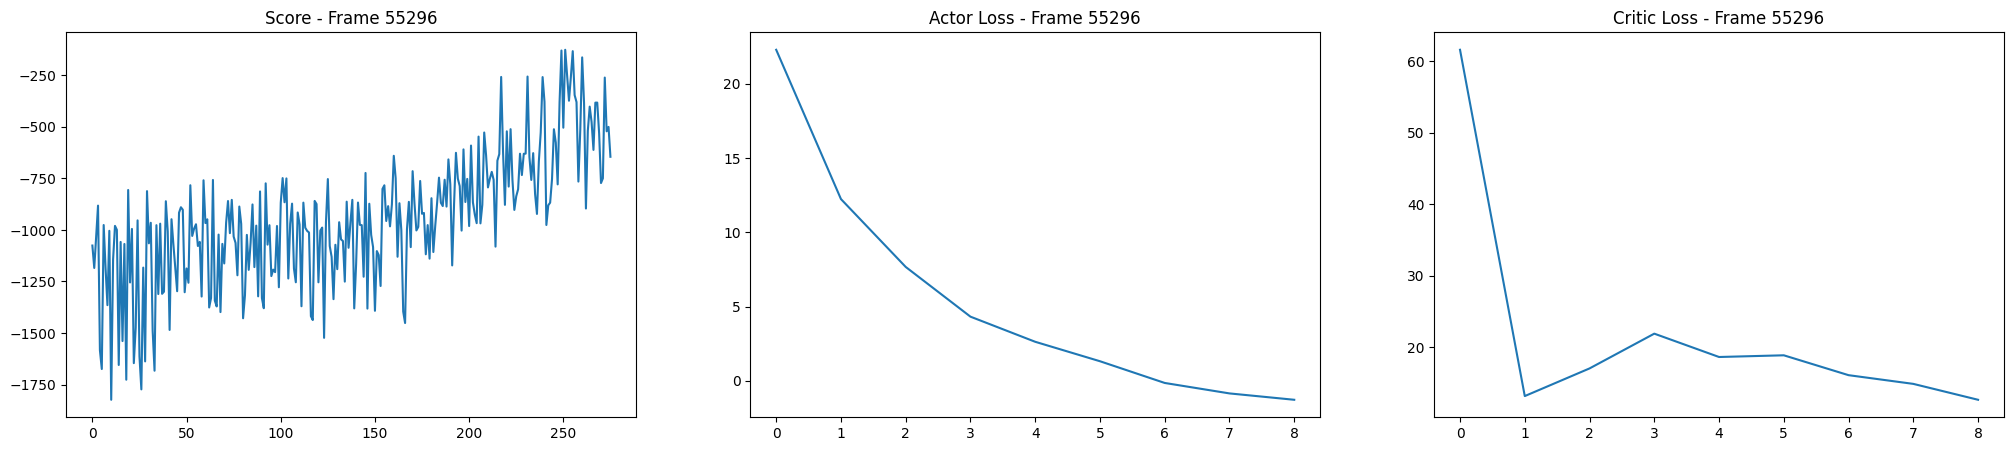

In [17]:
ppo_agent.train(num_frames)

## Train DDPG

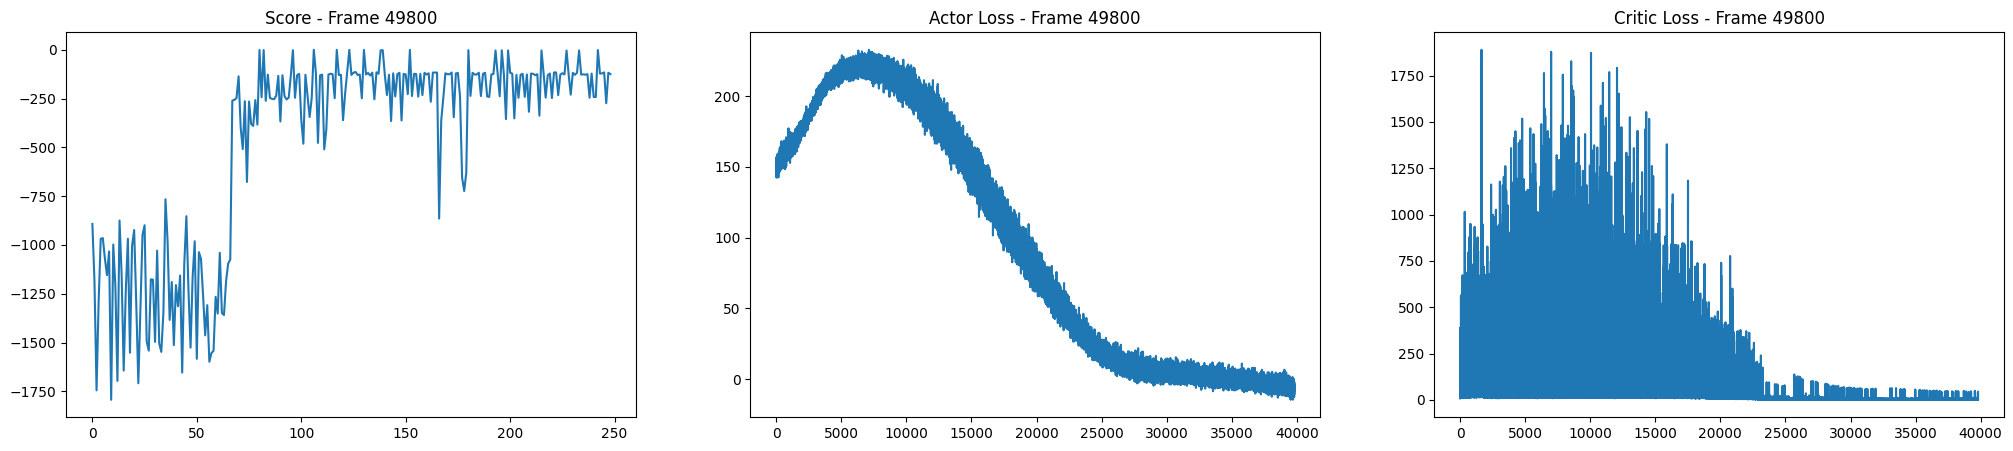

In [18]:
ddpg_agent.train(num_frames)

## Test

## Render

In [19]:
!sudo apt-get update
!pip install imageio
!sudo apt-get install -y xvfb ffmpeg
!pip install imageio-ffmpeg

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  Packages [975 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,029 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:13 http://archive.ubuntu.com/ubuntu focal-updates/unive

In [20]:
import imageio
import base64
import IPython

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_policy_eval_video(env, policy, filename, num_episodes=1, fps=30):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state = reset_env(env)
            video.append_data(env.render()[0])
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action = policy(state)
                state, reward, done = env_step(env, action.item())
                video.append_data(env.render()[0])
                if done:
                    break
    return embed_mp4(filename)

In [21]:
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [22]:
rendered_env = gym.make(env_id, render_mode='rgb_array')
rendered_env = ActionNormalizer(rendered_env)
env.seed(seed)

/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


[777]

In [23]:
ddpg_agent.is_test = True
create_policy_eval_video(rendered_env, ddpg_agent.select_action, 'ddpg')

<ipython-input-13-5ab26a05df29>:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_state = torch.tensor(state, dtype=torch.float32).to(self.device)


In [24]:
ppo_agent.is_test = True
create_policy_eval_video(rendered_env, ppo_agent.select_action, 'ppo')

<ipython-input-12-829575620a17>:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_state = torch.tensor(state, dtype=torch.float32).to(self.device).unsqueeze(0)


In [25]:
ddpg_agent.save_models()
ppo_agent.save_models()

In [26]:
# ddpg_agent.load_models()
# ppo_agent.load_models()